# Data Science ODL Project: Assessment 2

## Case study

#### This project needs to focus on the task of analyzing datasets from an insurance company in order to predict whether a customer poses a risk of committing insurance fraud. The goal is to develop, train, and validate 2 different models that can flag potential cases of fraud for further investigation and maintain a balanced error rate.

##### Main Objectives

* 1. Utilize a group of historical datasets that indicate cases of insurance fraud. The aim is to predict the likelihood of a customer committing insurance fraud.
* 2. Help the business by reducing the number of incorrect fraud predictions (both false positives and negatives). They could have direct financial implications - false positives lead to customer dissatisfaction and loss, while false negatives result in direct financial loss due to undetected fraud.
* 3. The insurance company requires an unbiased predictive model with a target error rate of 5%. The model should be able to flag potential fraud cases efficiently.

## 1. Aims, objectives and plan (4 marks)

### a) Aims and objectives
Develop a predictive model that identifies potential insurance fraud by analyzing the provided datasets in order to understand the characteristics of insurance fraud. We will Apply two machine learning techniques in order to identify fraud detection and then evaluate the models' performance in order to find out which approach is better suited for the task. Since this is a classification problem we are going to use classification models - RandomForest and KNN.

We will first prepare the data so that it can be easily fed to the prediction models, we will find the properties that are most closely correlated to the ReportedFraud and finally, we will fix any existing class imbalance before finally training the models.

The main objective of this project is to develop models that can accurately predict insurance fraud for our client, thus saving on operational costs and preserving customer relationships. 

###  b) Plan
Please demonstrate how you have conducted the project with a simple Gantt chart.

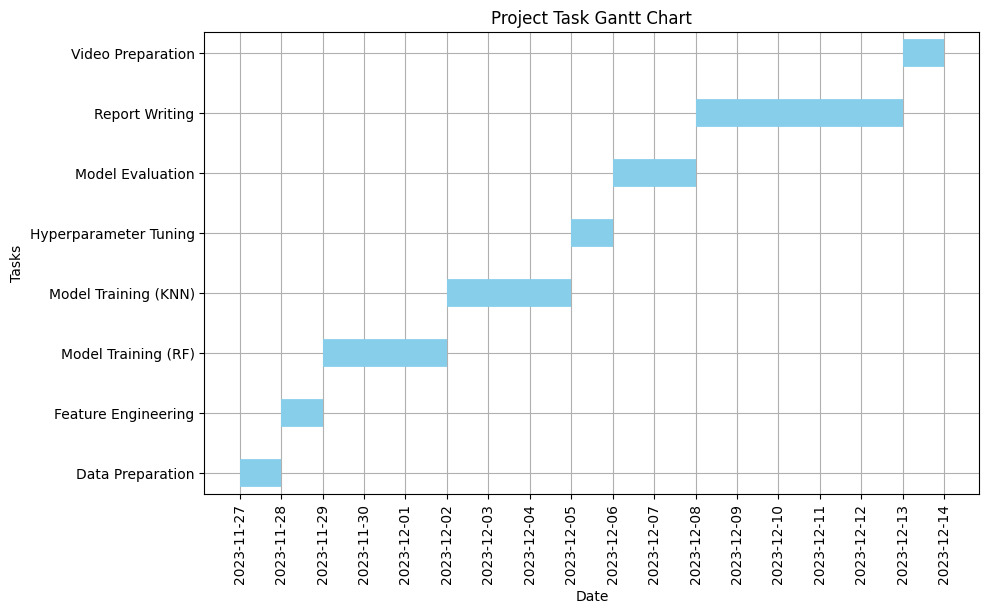

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime

# Task names and their durations
tasks = {
    "Data Preparation": 1,
    "Feature Engineering": 1,
    "Model Training (RF)": 3,
    "Model Training (KNN)": 3,
    "Hyperparameter Tuning": 1,
    "Model Evaluation": 2,
    "Report Writing": 5,
    "Video Preparation": 1
}

start_date = datetime.date(2023, 11, 27)

gantt_data = {
    "Task": [],
    "Start": [],
    "End": []
}

current_start = start_date
for task, duration in tasks.items():
    gantt_data["Task"].append(task)
    gantt_data["Start"].append(current_start)
    gantt_data["End"].append(current_start + datetime.timedelta(days=duration))
    current_start += datetime.timedelta(days=duration) 

gantt_df = pd.DataFrame(gantt_data)

# Convert start and end dates into matplotlib date format
gantt_df['Start'] = [mdates.date2num(date) for date in gantt_df['Start']]
gantt_df['End'] = [mdates.date2num(date) for date in gantt_df['End']]

fig, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=90)

plt.hlines(gantt_df['Task'], gantt_df['Start'], gantt_df['End'], colors='skyblue', lw=20)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.xlabel('Date')
plt.ylabel('Tasks')
plt.title('Project Task Gantt Chart')
plt.grid(True)

plt.show()


## 2. Understanding the case study (4 marks)

###  Case study analysis

1. __Data Complexity and Imbalance__: The first objective in the insurance fraud detection project is dealing with the complexity and potential imbalance in the dataset. Insurance fraud detection inherently deals with imbalanced records, as fraudulent claims are less frequent than true ones. To cope with this, I applied strategies like class imbalance optimization and considered balanced accuracy as a key metric. For the RandomForest and KNN models, techniques that includes feature engineering, dealing with missing data, and oversampling techniques like SMOTE were taken into consideration to ensure the integrity of the data and that there is no bias when feeding the data to the models.

2. __Feature Selection and Engineering__: The dataset incorporates numerous attributes, which include consumer demographics, coverage info, and claim statistics. Key features like 'InsuredZipCode', 'SeverityOfIncident', and 'CustomerLoyaltyPeriod' are vital for predicting fraud. Using RandomForest, I found the features that have the highest correlation to ReportedFraud. Additionally, feature engineering was carried out, which included developing new columns like 'DaysBetweenPolicyStartAndIncident' to seize temporal factors that might affect the chance of fraud.

3. __Model Selection and Evaluation__: I chose RandomForest and KNN for their robustness and potential to deal with classification tasks. RandomForest is useful for its performance in these types of tasks and performs well on imbalanced datasets. KNN, on the other hand, gives simplicity and performance and works fine with various feature sets in many instances when different data types or scales can be used within one class of data type.

4. __Business Impact and Model Interpretation__: Understanding the business impact is critical. Incorrectly flagged claims (fake positives) can cause consumer dissatisfaction, and overlooked frauds (false negatives) could bring about financial losses. Therefore, the models need to be focused on precision. The impact of prediction accuracy on consumer retention and overall business profitability was also considered.

## 3. Pre-processing applied (20 marks)
Enter the code in the cells below to execute each of the stated sub-tasks. 


###  a) Preparing the labels appropriately if necessary 

####  1. Importing the neccessary libraries

In [48]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

####  2. Reading datasets and converting them to DataFrames

In [49]:
claim_df = pd.read_csv('./archive/TrainData/TrainData/Train_Claim.csv')
demographics_df = pd.read_csv('./archive/TrainData/TrainData/Train_Demographics.csv')
policy_df = pd.read_csv('./archive/TrainData/TrainData/Train_Policy.csv')
vehicles_df = pd.read_csv('./archive/TrainData/TrainData/Train_Vehicle.csv')
trainData_with_target_df = pd.read_csv('./archive/TrainData/TrainData/Traindata_with_Target.csv')

###  b) Dealing with missing values if necessary 


####  1. Replace missing values with appropriate substitutes

In [50]:
claim_df['AmountOfTotalClaim'] = pd.to_numeric(claim_df['AmountOfTotalClaim'], errors='coerce')

AmountOfTotalClaim_mean = claim_df['AmountOfTotalClaim'].mean()

claim_df['AmountOfTotalClaim'].fillna(AmountOfTotalClaim_mean, inplace=True)

claim_df['AuthoritiesContacted'].replace(np.nan, 'False', inplace = True)

demographics_df['InsuredGender'].replace(np.nan, 'NA', inplace = True)

demographics_df['Country'].replace(np.nan, 'India', inplace = True)

####  2. Merge all dataframes on common column: 'CustomerID'

In [51]:
# Merging claim data with policy data
combined_df = pd.merge(claim_df, policy_df, on='CustomerID', how='inner')

# Merging the above result with demographics data
combined_df = pd.merge(combined_df, demographics_df, on='CustomerID', how='inner')

# Merging the result with vehicle data
combined_df = pd.merge(combined_df, vehicles_df, on='CustomerID', how='inner')

# Merging with the target data
combined_df = pd.merge(combined_df, trainData_with_target_df, on='CustomerID', how='inner')

# Casting CutomerID to integer
combined_df['CustomerID'] = combined_df['CustomerID'].str.replace('Cust', '').astype(int)

# Savig the new merged dataset
combined_df.to_csv('./archive/TrainData/TrainData/Combined_Dataset.csv', index=False)

###  c) Removing synonymous and noisy attributes if necessary 


####  1. Visualize attributes with high correlation

In [52]:
combined_df.corr(numeric_only=True).style.background_gradient(cmap='coolwarm')

,CustomerID,IncidentTime,NumberOfVehicles,BodilyInjuries,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,InsurancePolicyNumber,CustomerLoyaltyPeriod,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredAge,InsuredZipCode,CapitalGains,CapitalLoss
CustomerID,1.000000,-0.009473,-0.028060,-0.023945,-0.103496,-0.055687,-0.093827,-0.108726,1.000000,-0.006560,-0.007277,0.013256,-0.037251,0.000055,-0.012991,0.002451,0.010248
IncidentTime,-0.009473,1.000000,0.174673,-0.043154,0.272331,0.225956,0.218062,0.272001,-0.009473,0.094691,0.082753,-0.009471,-0.024493,0.114446,0.005870,-0.012895,-0.018026
NumberOfVehicles,-0.028060,0.174673,1.000000,0.019637,0.291109,0.254780,0.231888,0.287740,-0.028060,0.015138,0.042381,-0.055476,-0.025024,0.021664,0.015182,0.057967,-0.002662
BodilyInjuries,-0.023945,-0.043154,0.019637,1.000000,0.030976,0.031908,0.034103,0.026664,-0.023945,-0.021662,-0.031498,0.000452,0.039018,-0.027791,0.016280,0.055576,-0.029415
AmountOfTotalClaim,-0.103496,0.272331,0.291109,0.030976,1.000000,0.830940,0.841321,0.985635,-0.103496,0.065344,0.027211,-0.004963,-0.038112,0.070773,-0.021470,0.012423,-0.013980
AmountOfInjuryClaim,-0.055687,0.225956,0.254780,0.031908,0.830940,1.000000,0.622868,0.763172,-0.055687,0.073378,0.038940,-0.017979,-0.047432,0.083090,-0.014888,0.009078,-0.028032
AmountOfPropertyClaim,-0.093827,0.218062,0.231888,0.034103,0.841321,0.622868,1.000000,0.778821,-0.093827,0.055100,0.071897,-0.016531,-0.016722,0.075157,-0.002477,0.003841,-0.018501
AmountOfVehicleDamage,-0.108726,0.272001,0.287740,0.026664,0.985635,0.763172,0.778821,1.000000,-0.108726,0.060027,0.011136,0.002181,-0.037245,0.060257,-0.025969,0.014067,-0.008068
InsurancePolicyNumber,1.000000,-0.009473,-0.028060,-0.023945,-0.103496,-0.055687,-0.093827,-0.108726,1.000000,-0.006560,-0.007277,0.013256,-0.037251,0.000055,-0.012991,0.002451,0.010248
CustomerLoyaltyPeriod,-0.006560,0.094691,0.015138,-0.021662,0.065344,0.073378,0.055100,0.060027,-0.006560,1.000000,0.052474,0.025497,-0.001315,0.933219,0.040450,0.002118,0.022769


####  2. Confirm attributes with high correlation 

In [53]:
numerical_df = combined_df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_df.corr()
highly_correlated_pairs = correlation_matrix.unstack().sort_values(kind="quicksort", ascending=False)
high_correlation = highly_correlated_pairs[highly_correlated_pairs != 1] 

for pair in high_correlation.index:
    if high_correlation[pair] > 0.9:
        print(f"High correlation between: {pair}")

High correlation between: ('AmountOfVehicleDamage', 'AmountOfTotalClaim')
High correlation between: ('AmountOfTotalClaim', 'AmountOfVehicleDamage')
High correlation between: ('InsuredAge', 'CustomerLoyaltyPeriod')
High correlation between: ('CustomerLoyaltyPeriod', 'InsuredAge')


####  3. Clean Mixed-Type columns and convert Date columns to DateTime in order to extract features

In [54]:
combined_df['Witnesses'] = combined_df['Witnesses'].replace('MISSINGVALUE', np.nan)

combined_df['DateOfIncident'] = pd.to_datetime(combined_df['DateOfIncident'], errors='coerce')
combined_df['DateOfPolicyCoverage'] = pd.to_datetime(combined_df['DateOfPolicyCoverage'], errors='coerce')
combined_df['IncidentYear'] = combined_df['DateOfIncident'].dt.year
combined_df['IncidentMonth'] = combined_df['DateOfIncident'].dt.month
combined_df['IncidentDay'] = combined_df['DateOfIncident'].dt.day

combined_df['DaysBetweenPolicyStartAndIncident'] = (combined_df['DateOfIncident'] - combined_df['DateOfPolicyCoverage']).dt.days

####  4. Feature Engineering for Fraud Detection

In [55]:
combined_df['ClaimAmountDiscrepancy'] = combined_df['AmountOfTotalClaim'] - (combined_df['AmountOfInjuryClaim'] + combined_df['AmountOfPropertyClaim'] + combined_df['AmountOfVehicleDamage'])

####  5. Remove unnecessary columns

In [56]:
combined_df.drop(['DateOfIncident', 'DateOfPolicyCoverage', 'CustomerID', 'InsurancePolicyNumber'], axis=1, inplace=True)

####  6. Replace '?' with NaN in specific columns

In [57]:
combined_df['PropertyDamage'].replace('?', np.nan, inplace=True)
combined_df['PoliceReport'].replace('?', np.nan, inplace=True)

####  7. Perform value tranformations for non numerical columns

In [58]:
combined_df['ReportedFraud'] = combined_df['ReportedFraud'].map({'N': 0, 'Y': 1})

categorical_cols = ['TypeOfIncident', 'TypeOfCollission', 'SeverityOfIncident', 'AuthoritiesContacted', 
                    'InsuredRelationship', 'InsuredEducationLevel', 'InsuredOccupation', 'InsuredHobbies']

label_encoder = LabelEncoder()
for col in categorical_cols:
    combined_df[col] = label_encoder.fit_transform(combined_df[col])

combined_df['IncidentState'] = combined_df['IncidentState'].str.replace('State', '').astype(int)
combined_df['IncidentCity'] = combined_df['IncidentCity'].str.replace('City', '').astype(int)
combined_df['IncidentAddress'] = combined_df['IncidentAddress'].str.replace('Location ', '').astype(int)
combined_df['InsurancePolicyState'] = combined_df['InsurancePolicyState'].str.replace('State', '').astype(int)

combined_df['PropertyDamage'] = combined_df['PropertyDamage'].map({'NO': 0, 'YES': 1})
combined_df['PoliceReport'] = combined_df['PoliceReport'].map({'NO': 0, 'YES': 1})

combined_df['InsuredGender'] = combined_df['InsuredGender'].map({'MALE': 0, 'FEMALE': 1})

####  8. Handle miussing values for numerical and categorical columns

In [59]:
# For numerical columns
numerical_cols = combined_df.select_dtypes(include=['int32', 'float32']).columns
combined_df[numerical_cols] = combined_df[numerical_cols].fillna(combined_df[numerical_cols].mean())

# For categorical columns
categorical_cols = combined_df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    combined_df[col] = combined_df[col].fillna(combined_df[col].mode()[0])

####  9. Standardize numerical features 

In [60]:
scaler = StandardScaler()
combined_df[numerical_cols] = scaler.fit_transform(combined_df[numerical_cols])

####  10. SHandle and optimize categorical data 

In [61]:
# Handle categorical data
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

# Convert object types to category if they have a low cardinality
for col in combined_df.select_dtypes(include='object').columns:
    num_unique_values = len(combined_df[col].unique())
    num_total_values = len(combined_df[col])
    if num_unique_values / num_total_values < 0.5:
        combined_df[col] = combined_df[col].astype('category')
        
combined_df.dropna( inplace=True)

### e) Other

####  1. Utilyze Descriptive Statistics with the 'describe()' attribute in pandas in order to get summary statistics for each attribute

In [62]:
print(combined_df.describe())

       TypeOfIncident  TypeOfCollission  SeverityOfIncident  \
count    48080.000000      48080.000000        48080.000000   
mean         0.061300         -0.002539            0.022761   
std          1.001496          1.014322            0.974372   
min         -1.091458         -1.567032           -1.284761   
25%         -1.091458         -0.625029           -0.210208   
50%          0.764442          0.316974           -0.210208   
75%          0.764442          1.258977            0.864345   
max          1.692393          1.258977            1.938898   

       AuthoritiesContacted  IncidentState  IncidentCity  IncidentAddress  \
count          48080.000000   48080.000000  48080.000000     48080.000000   
mean              -0.004619      -0.003843      0.027714         0.033372   
std                0.999041       1.009071      0.983055         1.004836   
min               -1.551728      -1.999970     -1.443665        -1.731706   
25%               -0.871021      -0.877680     

#### 2. Plot key Insights for all columns of the dataset

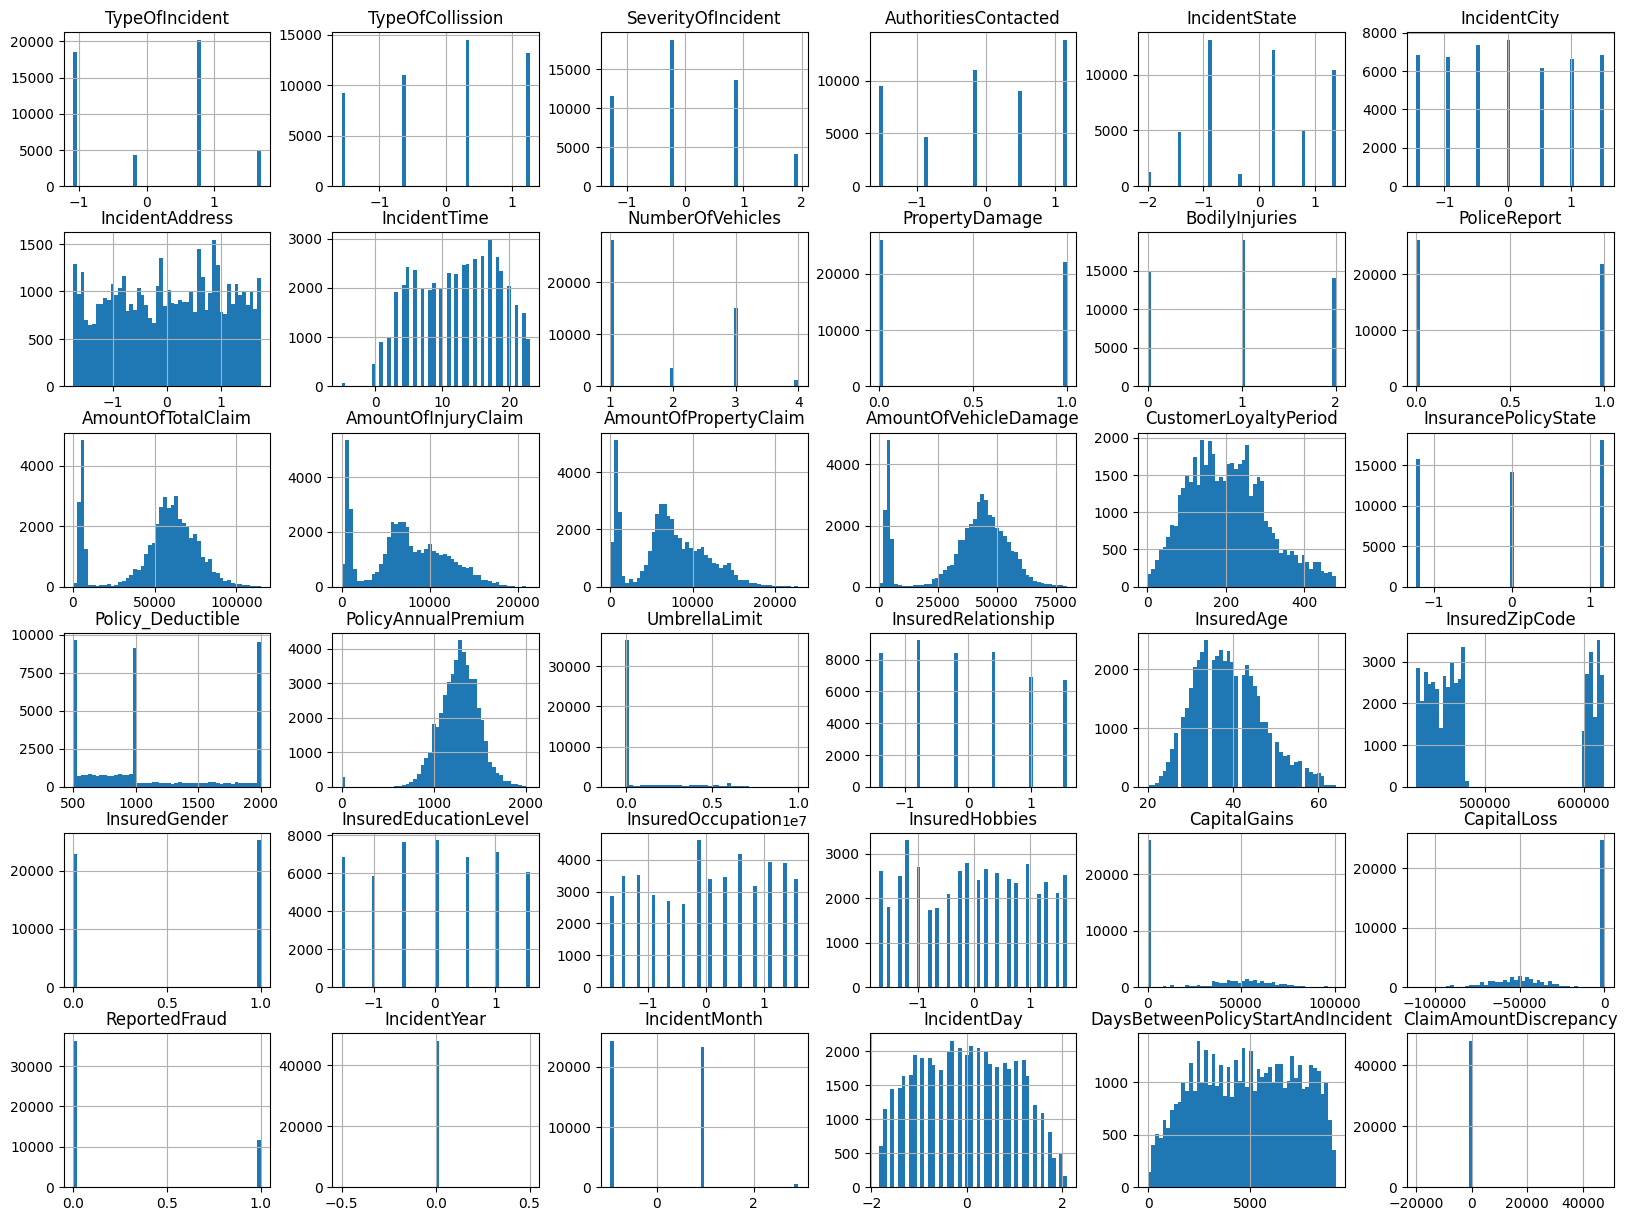

Index(['TypeOfIncident', 'TypeOfCollission', 'SeverityOfIncident',
       'AuthoritiesContacted', 'IncidentState', 'IncidentCity',
       'IncidentAddress', 'IncidentTime', 'NumberOfVehicles', 'PropertyDamage',
       ...
       'VehicleAttributeDetails_Vehicle9994',
       'VehicleAttributeDetails_Vehicle9995',
       'VehicleAttributeDetails_Vehicle9996',
       'VehicleAttributeDetails_Vehicle9997',
       'VehicleAttributeDetails_Vehicle9998',
       'VehicleAttributeDetails_Vehicle9999',
       'VehicleAttributeDetails_Volkswagen',
       'VehicleAttributeDetails_Wrangler', 'VehicleAttributeDetails_X5',
       'VehicleAttributeDetails_X6'],
      dtype='object', length=28960)


In [63]:
combined_df.hist(bins=50, figsize=(20,15))
plt.show()

print(combined_df.columns)


####  3. Analyze feature importance in regards to 'ReportedFraud'

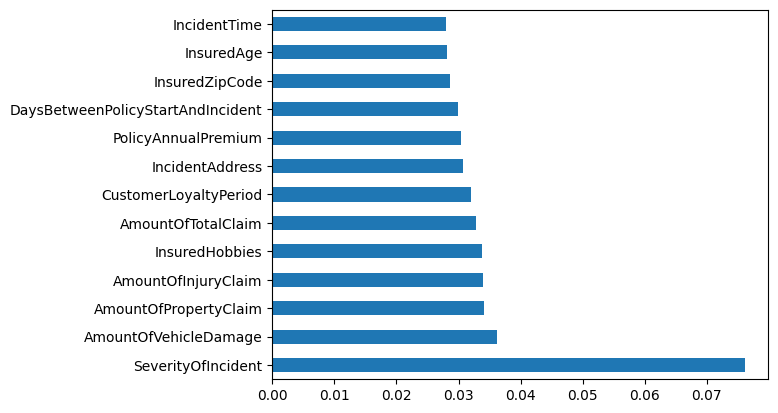

In [64]:
subset_df = combined_df.sample(frac=0.2)

rf = RandomForestClassifier(n_estimators=100, min_samples_split=4)
rf.fit(subset_df.drop('ReportedFraud', axis=1), subset_df['ReportedFraud'])

feature_importances = pd.Series(rf.feature_importances_, index=subset_df.drop('ReportedFraud', axis=1).columns)
feature_importances.nlargest(13).plot(kind='barh')
plt.show()

In [65]:
selected_columns = [
    'IncidentDay',
    'InsuredZipCode',
    'DaysBetweenPolicyStartAndIncident',
    'InsuredAge',
    'PolicyAnnualPremium',
    'IncidentAddress',
    'CustomerLoyaltyPeriod',
    'InsuredHobbies',
    'AmountOfInjuryClaim',
    'AmountOfPropertyClaim',
    'AmountOfVehicleDamage',
    'AmountOfTotalClaim',
    'SeverityOfIncident',
    'ReportedFraud'
]

# Creating the new DataFrame with selected columns
filtered_df = combined_df[selected_columns]

####  4. Check class distribution for imbalance

In [66]:
class_distribution = filtered_df['ReportedFraud'].value_counts(normalize=True)
print("Class distribution:\n", class_distribution)

Class distribution:
 ReportedFraud
0    0.754409
1    0.245591
Name: proportion, dtype: float64


#### 5. Define datasets for the 2 machine learning methods

In [67]:
rf_df = filtered_df
lr_df = filtered_df

## 4. RandomForest

### a) Discuss your motivation for choosing the technique and provide a schematic figure of the process

##### My motivation for deciding on RandomForest as the first method stems from its robustness and effectiveness in managing complex type of responsibilities like insurance fraud detection. RandomForest functions by creating multiple decision trees during the training phase and outputs the class that represents the mode of the classes predicted by the individual trees. This technique offers several inherent advantages:

__Handling Non-Linear Data__: Insurance fraud datasets regularly incorporate complex, non-linear relationships. RandomForest can seize these intricacies without the want for sizable facts transformation.

__Feature Importance__: It offers insights into function significance, critical for determining which factors have the biggest impact on the chance of fraud.

__Reduced Overfitting__: The ensemble nature of RandomForest reduces the threat of overfitting, which is a common issue in decision tree models, making it more generalizable.

__Versatility with Imbalanced Data__: It performs well on imbalanced datasets, which is standard in fraud detection situations, by constructing trees that manage class imbalance.

Below is a schematic parent of the RandomForest process within the context of fraud detection:

__Input Data__: Feeding the pre-processed dataset into the model.

__Building Multiple Trees__: Constructing numerous decision trees on diverse facts subsets.

__Decision Making__: Each tree makes a choice (fraud or not fraud).

__Aggregating Results__: Combining the decisions from all decision trees in order to make a final decision based on majority voting.

__Output__: The very last prediction indicating the chance of being fraudulent.

![RandomForest Process](random_forest_flow_chart_diagram.png)

__diagram source__: https://www.researchgate.net/figure/Flow-chart-of-random-forest-algorithm_fig4_341224118

__This diagrammatic representation shows the step-by-step process of how RandomForest operates, highlighting its systematic approach in tackling complex classification tasks.__

#### Creating a function that shows performance metrics

In [68]:
def performance_metrics(classifier, X_train, y_train):
    classifier.fit(X_train, y_train)
    y_train_pred = classifier.predict(X_train)
    
    train_cm = confusion_matrix(y_train, y_train_pred)
    train_cr = classification_report(y_train, y_train_pred)
    
    print(train_cm)
    print(train_cr)

#### Creating a function that performs cross-validation

In [69]:
def cross_validation(classifier, X_test, y_test, cv, scoring):
    cv_scores = cross_val_score(classifier, X_test, y_test, cv=cv, scoring=scoring)
    
    print(f"Cross-validation balanced accuracy scores: {cv_scores}")
    print(f"Mean balanced accuracy score: {np.mean(cv_scores)}")
    print(f"Standard deviation of balanced accuracy score: {np.std(cv_scores)}")

### b) Setting hyper parameters with rationale

In [70]:
X_rf = rf_df.drop('ReportedFraud', axis=1) 
y_rf = rf_df['ReportedFraud']

X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)

balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)

#### Fix class ditribution imbalance

In [71]:
smote = SMOTE(random_state=42)
X_rf_train_smote, y_rf_train_smote = smote.fit_resample(X_rf_train, y_rf_train)

print(pd.Series(y_rf_train_smote).value_counts())

ReportedFraud
1    25393
0    25393
Name: count, dtype: int64


In [72]:
rf_classifier = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=2,
                                       min_samples_leaf=4, random_state=42)

#### Performance metrics for unoptimized hyper parameters

In [73]:
performance_metrics(rf_classifier, X_rf_train_smote, y_rf_train_smote)

[[25219   174]
 [  199 25194]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     25393
           1       0.99      0.99      0.99     25393

    accuracy                           0.99     50786
   macro avg       0.99      0.99      0.99     50786
weighted avg       0.99      0.99      0.99     50786



### c) Optimising hyper parameters


In [74]:
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search_rf = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_distributions,
    n_iter=10,
    scoring=make_scorer(balanced_accuracy_score),
    cv=5,
    n_jobs=-1,
    random_state=42,
)

random_search_rf.fit(X_rf_train_smote, y_rf_train_smote)

print(f"Best parameters found: {random_search_rf.best_params_}")

Best parameters found: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}


### d) Performance metrics for training

In [75]:
# Use the best estimator found by the random search
rf_classifier_optimized = random_search_rf.best_estimator_

performance_metrics(rf_classifier_optimized, X_rf_train_smote, y_rf_train_smote)

[[25393     0]
 [    0 25393]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25393
           1       1.00      1.00      1.00     25393

    accuracy                           1.00     50786
   macro avg       1.00      1.00      1.00     50786
weighted avg       1.00      1.00      1.00     50786



### e) Cross-validation

In [76]:
cross_validation(rf_classifier_optimized, X_rf_test, y_rf_test, 5, balanced_accuracy_scorer)

Cross-validation balanced accuracy scores: [0.92971634 0.93322656 0.92424085 0.92783047 0.92210625]
Mean balanced accuracy score: 0.9274240947965928
Standard deviation of balanced accuracy score: 0.003937018663139025


## 5. K-Nearest Neighbors (KNN)

### a) Discuss your motivation for choosing the technique and  provide a schematic figure of the process

#### My motivation for deciding on K-nearest neighbor (KNN) as the second method stems from the fact that it is a simple algorithm that is easy to understand and good at classification of tasks. KNN stands as a nonparametric procedure for predicting an instance that relates it with its nearest neighbors discovered in the feature space. It is especially applicable for those situations, wherein it is a relatively close relationship between the features and the class labels, as well as data points that are near each other but not linear.

##### Key motivations for selecting KNN include:

__Similarity-Based Decision Making__:  KNN is a classifier that categorizes instances based on similarity with different instances in a training dataset.
This method is applied for getting nonparametric estimates on complex dependence without any reference distribution assumption.

__Flexibility in Feature Space__: This is why KNN works fine with various feature sets in many instances when different data types or scales can be used within one class of data type.

__Ease of Implementation__: Simple to implement, as well as quick prototyping and testing; therefore it is good for KNN.

#### Below is a schematic figure of the KNN process:

__Input Data__: The model takes a pre-processed dataset as an input.

__Neighbor Search__: For every query instance, the model finds the nearest neighbors in the training set.

__Voting__: As a rule, it comes up with a vote on the basis of the class belongingness of their nearest neighbor.

__Output__: The final labels for each of these occurrences.

![KNN Schematic](knn_diagram1.png)

__diagram source__: https://www.researchgate.net/figure/Flow-diagram-of-the-serial-implementation-of-the-KNN-filtering-algorithm_fig5_326472969

As can be seen in the figure, the whole approach of using knn to detect fraud relies extensively on the idea that there is a certain pattern within which points differ and some cluster exists in the feature space.

Enter the correct code in the cells below to execute each of the stated sub-tasks.
### b) Setting hyper parameters with rationale


In [77]:
X_knn = lr_df.drop('ReportedFraud', axis=1) 
y_knn = lr_df['ReportedFraud']

X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(X_knn, y_knn, test_size=0.3, random_state=42)

#### Fix class ditribution imbalance

In [78]:
smote = SMOTE(random_state=42)
X_knn_train_smote, y_knn_train_smote = smote.fit_resample(X_knn_train, y_knn_train)

print(pd.Series(y_knn_train_smote).value_counts())

ReportedFraud
1    25393
0    25393
Name: count, dtype: int64


In [79]:
knn = KNeighborsClassifier(n_neighbors=1)

#### Performance metrics for unoptimized hyper parameters

In [80]:
performance_metrics(knn, X_knn_train_smote, y_knn_train_smote)

[[25393     0]
 [    0 25393]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25393
           1       1.00      1.00      1.00     25393

    accuracy                           1.00     50786
   macro avg       1.00      1.00      1.00     50786
weighted avg       1.00      1.00      1.00     50786



### c) Optimising hyper parameters


In [81]:
param_grid_knn = {'n_neighbors': range(1, 31), 'weights': ['uniform', 'distance']}

random_search_knn = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_grid_knn,
    n_iter=10,
    scoring=balanced_accuracy_scorer,
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search_knn.fit(X_knn_train_smote, y_knn_train_smote)

print(f"Best parameters found: {random_search_knn.best_params_}")

Best parameters found: {'weights': 'uniform', 'n_neighbors': 1}


### d) Performance metrics for training

In [82]:
# Use the best estimator found by the random search
knn_classifier_optimized = random_search_knn.best_estimator_

performance_metrics(knn_classifier_optimized, X_knn_train_smote, y_knn_train_smote)

[[25393     0]
 [    0 25393]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25393
           1       1.00      1.00      1.00     25393

    accuracy                           1.00     50786
   macro avg       1.00      1.00      1.00     50786
weighted avg       1.00      1.00      1.00     50786



### e) Perform cross validation testing on optimize hyper-parameters 

In [83]:
cross_validation(knn_classifier_optimized, X_knn_test, y_knn_test, cv=5, scoring=balanced_accuracy_scorer)

Cross-validation balanced accuracy scores: [0.88752282 0.88471782 0.87593856 0.89172237 0.8799679 ]
Mean balanced accuracy score: 0.883973893589949
Standard deviation of balanced accuracy score: 0.005546199335947419


## 6. Comparison of metrics performance for testing (16 marks)
Enter the correct code in the cells below to execute each of the stated sub-tasks. 


### a) Use of cross validation for both techniques to deal with over-fitting

In [84]:
print('Cross validation for RandomForest')
cross_validation(rf_classifier_optimized, X_rf_test, y_rf_test, 5, balanced_accuracy_scorer)

print('-----------------------------------------------------------------------------------')

print('Cross validation for KNN')
cross_validation(knn_classifier_optimized, X_knn_test, y_knn_test, cv=5, scoring=balanced_accuracy_scorer)

Cross validation for RandomForest
Cross-validation balanced accuracy scores: [0.92971634 0.93322656 0.92424085 0.92783047 0.92210625]
Mean balanced accuracy score: 0.9274240947965928
Standard deviation of balanced accuracy score: 0.003937018663139025
-----------------------------------------------------------------------------------
Cross validation for KNN
Cross-validation balanced accuracy scores: [0.88752282 0.88471782 0.87593856 0.89172237 0.8799679 ]
Mean balanced accuracy score: 0.883973893589949
Standard deviation of balanced accuracy score: 0.005546199335947419


### b) Comparison with appropriate metrics for testing

In [85]:
y_test_pred_rf = rf_classifier_optimized.predict(X_rf_test)

y_test_pred_knn = knn_classifier_optimized.predict(X_knn_test)

accuracy_rf = balanced_accuracy_score(y_rf_test, y_test_pred_rf)
precision_rf = precision_score(y_rf_test, y_test_pred_rf)
recall_rf = recall_score(y_rf_test, y_test_pred_rf)
f1_rf = f1_score(y_rf_test, y_test_pred_rf)
roc_auc_rf = roc_auc_score(y_rf_test, y_test_pred_rf)

accuracy_knn = balanced_accuracy_score(y_knn_test, y_test_pred_knn)
precision_knn = precision_score(y_knn_test, y_test_pred_knn)
recall_knn = recall_score(y_knn_test, y_test_pred_knn)
f1_knn = f1_score(y_knn_test, y_test_pred_knn)
roc_auc_knn = roc_auc_score(y_knn_test, y_test_pred_knn)

print("RandomForest Performance Metrics:")
print(f"Balanced Accuracy: {accuracy_rf}, Precision: {precision_rf}, Recall: {recall_rf}, F1 Score: {f1_rf}, ROC AUC: {roc_auc_rf}\n")

print("KNN Performance Metrics:")
print(f"Balanced Accuracy: {accuracy_knn}, Precision: {precision_knn}, Recall: {recall_knn}, F1 Score: {f1_knn}, ROC AUC: {roc_auc_knn}")


RandomForest Performance Metrics:
Balanced Accuracy: 0.9955245616903259, Precision: 0.9898904802021904, Recall: 0.9943582510578279, F1 Score: 0.9921193357725865, ROC AUC: 0.995524561690326

KNN Performance Metrics:
Balanced Accuracy: 0.9925198467927301, Precision: 0.9887165021156559, Recall: 0.9887165021156559, F1 Score: 0.9887165021156559, ROC AUC: 0.99251984679273


### c) Model selection (ROC or other charts)

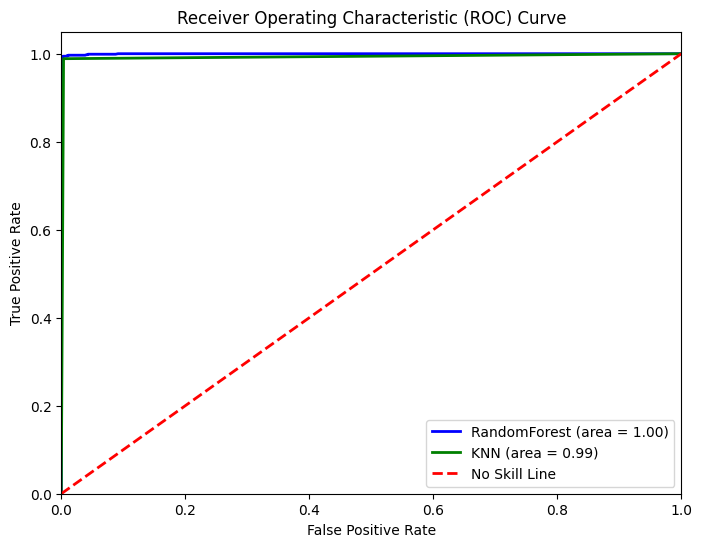

In [86]:
# Compute ROC curve and ROC area for RandomForest
fpr_rf, tpr_rf, _ = roc_curve(y_rf_test, rf_classifier_optimized.predict_proba(X_rf_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Compute ROC curve and ROC area for KNN
fpr_knn, tpr_knn, _ = roc_curve(y_knn_test, knn_classifier_optimized.predict_proba(X_knn_test)[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'RandomForest (area = {roc_auc_rf:.2f})')
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label=f'KNN (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='No Skill Line')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## 7. Final recommendation of best model (8 marks)

### a) Discuss the results from a technical perspective, for example, overfitting discussion, complexity and efficiency

The results from the RandomForest and KNN classifiers, both effective machine learning models for classification tasks, show impressive performance metrics. However, the high performance on the training set shows near-perfect accuracy and F1 scores, and this could be indicative of overfitting. In some cases models that perfectly predict the training data may have learned to memorize the training set rather than generalize from it.

The RandomForest model is an ensemble method, known for its ability to reduce overfitting by averaging the predictions of several individual decision trees. Nevertheless, the perfect score in the training phase suggests that the model could be capturing noise along with the underlying data patterns. After cross-validation, the results with a mean balanced accuracy score of approximately 0.927 provide reassurance about the model's generalization capabilities, but there is still a gap remaining between the training and validation scores, which could be indicative of overfitting.

The KNN classifier’s accuracy is slightly less than the RandomForest classifier, but it is still high enough for accurately detecting insurance fraud. Given that the reason for KNN's complexity is the choice of 'k', the number of neighbors, the optimized value here shows a balance between the model's simplicity and its ability to capture the nuances within the data. After conducting cross-validation we achieved a balanced accuracy of approximately 0.884. This shows the model's generalization ability, but it also suggests that some overfitting could have occurred, given the perfect training scores.

In terms of efficiency, KNN can be more computationally intensive than RandomForest during its prediction, because of the search operations for the nearest neighbors, while RandomForest generally requires more memory and computational power than KNN during the training phase due to the construction of multiple decision trees.

The ROC curve analysis is crucial for both models. The AUC values are close to 1.00 and this suggests that the performance of the models is excellent. However, the true test is whether the models can maintain this performance on entirely unseen data. The high training scores should indicate that the models need to be reviewed more critically for any signs of overfitting. Further tests with another set, or even better, a real-world application, could provide additional insights into their true predictive power.

### b) Discuss the results from a business perspective, for example, results interpretation, relevance and balance with technical perspective

From a business perspective, the results of applying RandomForest and KNN models are particularly relevant due to the significant impact of fraudulent claims on an insurance company's profitability and customer trust. Even though the balanced accuracy we achieved for both models after cross-validation (0.92, 0.88) does not quite reach the customer requirements of 0.95, the high accuracy and ROC AUC scores indicate that both models are effective enough at identifying insurance fraud, which can lead to considerable cost savings and more efficient allocation of investigative resources for the company.

The RandomForest model shows a slightly better performance than KNN. This would be particularly attractive as it could potentially reduce the number of false positives — legitimate claims incorrectly flagged as fraudulent. This is critical as it minimizes the risk of alienating customers by wrongfully accusing them of committing fraud. The high precision of the RandomForest model could help the company by reducing the number of genuine claims that have to be investigated, thus saving on operational costs and preserving customer relationships.

However, a balance between technical excellence and operational efficiency must be achieved. The KNN model may be slightly less accurate but it could offer faster prediction times. This tradeoff can be beneficial if the model is implemented in a real-time fraud detection system where decisions need to be made quickly.

In summary, the choice between the 2 models from a business standpoint should be made considering not only the precision and recall of the model but also its desired application and subsequent impact on customer satisfaction and operational efficiency. The slight trade-off in accuracy for the KNN model could be justified as long as it leads to faster processing times and lower computational costs, depending on the customer's specific business requirements, desired application, and infrastructure capabilities.


## 8. Conclusion (8 marks)

### a) What has been successfully accomplished and what has not been successful?

In this data science project, we have successfully created and evaluated two machine learning models—RandomForest and KNN—to address the issue of insurance fraud detection. The RandomForest model demonstrated a strong performance with high precision and recall. This shows its strength in detecting fraudulent claims. The KNN model may be slightly less precise but still performed admirably and showed that it could offer faster prediction times due to the simplicity of its nature.

On the flip side, the project faced challenges. The perfection of scores on the training set for both models raises concerns about overfitting, although cross-validation results suggest that the models still generalize well. The question is whether these models would maintain their high performance on a completely unseen dataset, as real-world data could present patterns not captured in the training phase.

Lastly, due to the 2 model limitation listed in the assignment brief, the project has not explored alternative models that could potentially provide better insight or computational efficiency. Ensemble methods other than RandomForest, deep learning approaches, or anomaly detection algorithms might offer improved or more cost-effective results.

In summary, the project's success lies in demonstrating the feasibility of using machine learning for fraud detection and providing a solid foundation for further refinement. The need for continued improvement remains, particularly in addressing potential overfitting and exploring a wider array of models to enhance predictive performance.


### b) Reflecting back on the analysis, what could you have done differently if you were to do the project again?

By reflecting back on the analysis of this task, we can find a few areas in which implementing different approaches could enhance the performance of the models. Firstly, more rigorous feature engineering could be implemented, secondly, while the implemented preprocessing handles missing values and scales numeric features, taking the time to explore more interactions between features, such as the relationship between claim amount and policy details, could provide us with additional insights.

Given the importance of the task, deploying more advanced machine learning algorithms such as Deep learning models could improve our prediction accuracy since these kinds of models can capture more complex patterns and relationships in the data than simpler models like the ones we have used may miss.

Optimizing hyperparameters could also be done in a better way by using a more robust search like Bayesian optimization. This way we could fine-tune the model better.

The class imbalance problem was addressed by using SMOTE alternative methods such as adjusting class weights or employing anomaly detection algorithms could be explored, since the prevalence of fraud cases is typically low in real-world scenarios, these methods might be more appropriate.

The implementation of these changes could lead to a more robust and business-friendly solution that can provide higher confidence in detecting fraud and thus reduce the financial impact on the company.

### c) Provide a wish list of future work that you would like to do

In the future development of this project, I would experiment with more machine-learning techniques in order to find out if we can provide higher balanced accuracy closer to the user specifications. I would also explore more advanced approaches like deep learning, particularly neural networks since they might be more adept at identifying more complex fraudulent patterns.

It would be beneficial to also incorporate a more domain-specific approach into the feature engineering process. This could be done by creating interaction terms in order to find more nuanced relationships within different data sources. This could provide complementary insights, such as external fraud databases or social media analysis.

A more robust and thorough hyperparameter optimization process could provide us with better model performance. Experimenting with cost-sensitive learning in order to directly incorporate financial implications, false positives, and false negatives into the model during the training phase could be beneficial.

Lastly, developing a more robust model interpretability framework would provide clearer explanations about the model's decisions to the stakeholder and we can achieve that with tools such as LIME (explains individual predictions of any classifier or regressor in an interpretable and faithful manner) or SHAP (SHapley Additive exPlanations, offers a unified approach to explain the output of any machine learning model). With this, we can not only increase the trust in the model’s predictions but we can also ensure that the outputs align with the business goals and requirements.